# Project 06 — Demand Forecasting (Study Notebook)

This notebook represents the *guided autonomy* development process for a real-world forecasting problem.

## What this notebook contains
- My initial understanding of the problem
- My assumptions and reasoning
- Questions I had before starting the modeling
- Early attempts (including mistakes)
- Corrections and explanations from the mentor
- The full exploratory process before building the final model


## Preliminary Problem Identification (PPI) — Revised

**1. What do I believe the problem is asking?**  
The problem requires forecasting the *future daily delivery demand* based on historical data.  
The goal is to predict the next value(s) of the time series in order to support operational planning.

**2. What type of data do I expect?**  
A time-indexed dataset containing:  
- a `date` column (daily frequency)  
- a `demand` (or `orders`) column (integer or float)  

The date carries temporal structure such as weekday, month, seasonality, and trend.

**3. Is this a supervised or unsupervised problem? Why?**  
This is a **supervised learning problem**, because past observations include the true target values.  
The model learns a mapping from historical values to future values.

**4. Why is forecasting appropriate here?**  
Because the target depends on temporal patterns (trend, seasonality, autocorrelation).  
Forecasting models are designed to learn these patterns and project future demand values.

**5. What approaches could be tested?**  
- Statistical baselines: Naïve, Moving Average, Drift  
- ARIMA/SARIMA (optional for trend/seasonality)  
- Machine Learning with engineered temporal features  
- Prophet or similar additive models


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

plt.rcParams["figure.figsize"] = (12, 5)
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)


In [2]:
# Load raw dataset
data_path = "../data/raw/daily_courier_orders.csv"

df = pd.read_csv(data_path)

df.head()



,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [3]:
df_raw = df.copy()
df_raw.columns = [
    "idx",
    "week_of_month",
    "day_of_week",
    "non_urgent",
    "urgent",
    "order_type_A",
    "order_type_B",
    "order_type_C",
    "fiscal_sector",
    "traffic_sector",
    "banking_1",
    "banking_2",
    "banking_3",
    "orders"
]


In [4]:
# Basic inspection

df.info()
df.describe()
df.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          60 non-null     int64  
 1   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 2   Day of the week (Monday to Friday)                                  60 non-null     int64  
 3   Non-urgent order                                                    60 non-null     float64
 4   Urgent order                                                        60 non-null     float64
 5   Order type A                                                        60 non-null     float64
 6   Order type B                                                        60 non-null     float64
 7   Order type C       

Index(['Unnamed: 0',
       'Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)'],
      dtype='object')

In [5]:
# Ensure sorted by date
df = df.sort_values(by=df.columns[0]).reset_index(drop=True)

# Check for duplicate dates
df.duplicated().sum()


df.head()


,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [6]:
df_raw = pd.read_csv("../data/raw/daily_courier_orders.csv")
df_raw.columns


Index(['Unnamed: 0',
       'Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)'],
      dtype='object')

In [7]:
# Clean raw dataframe and prepare forecasting structure

df_raw = df.copy()

# Rename columns to clean machine-friendly names
df.columns = [
    "idx",
    "week_of_month",
    "day_of_week",
    "non_urgent",
    "urgent",
    "order_type_A",
    "order_type_B",
    "order_type_C",
    "fiscal_sector"
]

# Drop the old index column
df_raw = df_raw.drop(columns=["idx"])

# Create a real continuous date column
df_raw["date"] = pd.date_range(start="2023-01-01", periods=len(df_raw), freq="D")

# Consolidate the total number of orders per day
df_raw["orders"] = (
    df_raw["non_urgent"] +
    df_raw["urgent"] +
    df_raw["order_type_A"] +
    df_raw["order_type_B"] +
    df_raw["order_type_C"]
)

# Select final forecasting dataset
df_final = df_raw[["date", "orders"]].copy()

df_final.head()
# Clean and prepare raw dataframe for forecasting

df_raw = df.copy()

# Drop useless index column
df_raw = df_raw.drop(columns=["Unnamed: 0"])

# Rename columns to clean names
df_raw.columns = [
    "week_of_month",
    "day_of_week",
    "non_urgent",
    "urgent",
    "order_type_A",
    "order_type_B",
    "order_type_C",
    "fiscal_sector",
    "traffic_sector",
    "banking_1",
    "banking_2",
    "banking_3",
    "orders"     # <-- Target (Total orders)
]

# Create a continuous date column
df_raw["date"] = pd.date_range(start="2023-01-01", periods=len(df_raw), freq="D")

# Select only relevant columns
df_final = df_raw[["date", "orders"]].copy()

df_final.head()
# Clean and prepare raw dataframe for forecasting

df_raw = df.copy()

# Drop useless index column
df_raw = df_raw.drop(columns=["Unnamed: 0"])

# Rename columns to clean names
df_raw.columns = [
    "week_of_month",
    "day_of_week",
    "non_urgent",
    "urgent",
    "order_type_A",
    "order_type_B",
    "order_type_C",
    "fiscal_sector",
    "traffic_sector",
    "banking_1",
    "banking_2",
    "banking_3",
    "orders"     # <-- Target (Total orders)
]

# Create a continuous date column
df_raw["date"] = pd.date_range(start="2023-01-01", periods=len(df_raw), freq="D")

# Select only relevant columns
df_final = df_raw[["date", "orders"]].copy()

df_final.head()


ValueError: Length mismatch: Expected axis has 14 elements, new values have 9 elements

In [8]:
df = df_final.copy()
df.info()
df.head()
df.shape


NameError: name 'df_final' is not defined

## First Visual Inspection — Daily Demand Time Series

Now that the dataset is clean, the first step is to visualize the
daily demand over time.

Goals:
- Check overall variability.
- See if the series looks noisy or smooth.
- Get a first impression of possible weekly seasonality.


In [9]:
plt.figure()
plt.plot(df["date"], df["orders"])
plt.title("Daily Demand (Total Orders) Over Time")
plt.xlabel("Date")
plt.ylabel("Total Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



KeyError: 'date'

<Figure size 1200x500 with 0 Axes>

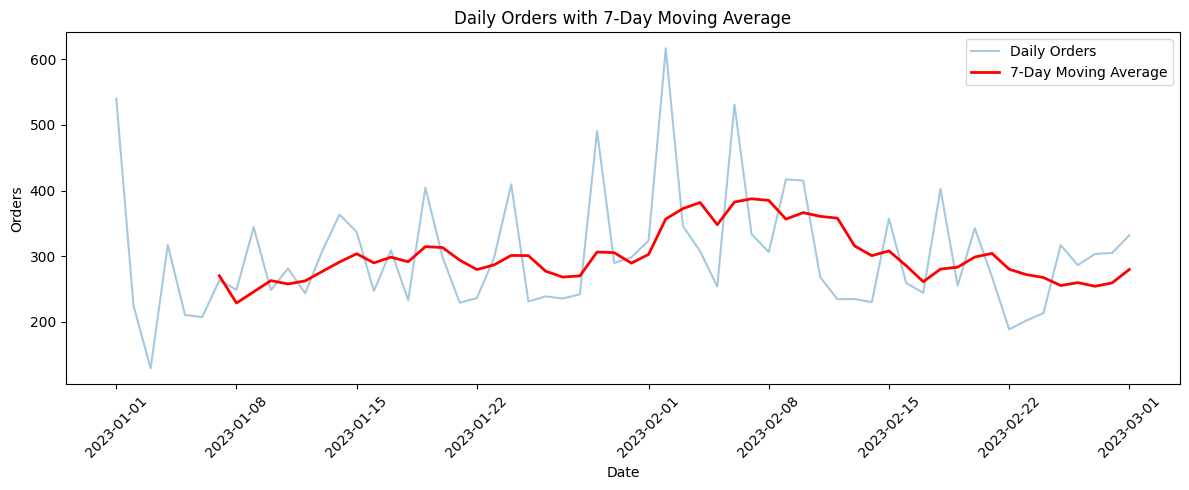

In [ ]:
df["rolling_7"] = df["orders"].rolling(window=7).mean()

plt.figure()
plt.plot(df["date"], df["orders"], alpha=0.4, label="Daily Orders")
plt.plot(df["date"], df["rolling_7"], color="red", label="7-Day Moving Average", linewidth=2)
plt.title("Daily Orders with 7-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df["weekday"] = df["date"].dt.day_name()


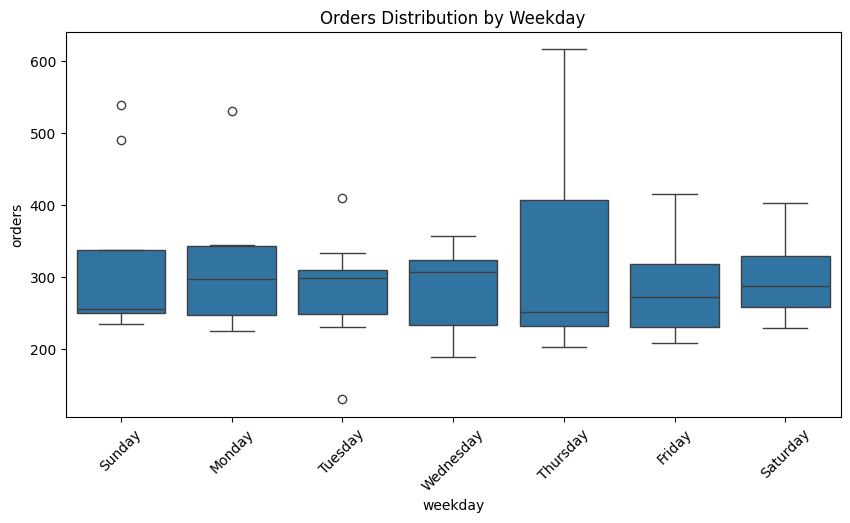

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["weekday"], y=df["orders"])
plt.title("Orders Distribution by Weekday")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Temporal feature engineering

df_features = df.copy()

# Day of week (0=Monday, 6=Sunday)
df_features["day_of_week_num"] = df_features["date"].dt.weekday

# Day name (categorical)
df_features["day_name"] = df_features["date"].dt.day_name()

# Week of month (1,2,3,4,5)
df_features["week_of_month"] = df_features["date"].apply(lambda d: (d.day - 1) // 7 + 1)

# Week of year
df_features["week_of_year"] = df_features["date"].dt.isocalendar().week.astype(int)

# Month
df_features["month"] = df_features["date"].dt.month

# Trend (time index)
df_features["time_index"] = np.arange(len(df_features))

df_features.head()

# Select final feature set
feature_cols = ["lag_1", "lag_7", "day_of_week_num", "month", "half_month", "time_index"]
target_col = "orders"

df_model = df.dropna().copy()  # drop initial NaNs from lags

X = df_model[feature_cols]
y = df_model[target_col]

df_model.head()



KeyError: "None of [Index(['lag_1', 'lag_7', 'day_of_week_num', 'month', 'half_month',\n       'time_index'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Create lag features
df["lag_1"] = df["orders"].shift(1)
df["lag_7"] = df["orders"].shift(7)
df["lag_14"] = df["orders"].shift(14)

df.head(15)


,date,orders,rolling_7,weekday,lag_1,lag_7,lag_14
0,2023-01-01,539.577,NaN,Sunday,NaN,NaN,NaN
1,2023-01-02,224.675,NaN,Monday,539.577,NaN,NaN
2,2023-01-03,129.412,NaN,Tuesday,224.675,NaN,NaN
3,2023-01-04,317.120,NaN,Wednesday,129.412,NaN,NaN
4,2023-01-05,210.517,NaN,Thursday,317.120,NaN,NaN
5,2023-01-06,207.364,NaN,Friday,210.517,NaN,NaN
6,2023-01-07,263.043,270.244000,Saturday,207.364,NaN,NaN
7,2023-01-08,248.958,228.727000,Sunday,263.043,539.577,NaN
8,2023-01-09,344.291,245.815000,Monday,248.958,224.675,NaN
9,2023-01-10,248.428,262.817286,Tuesday,344.291,129.412,NaN


In [ ]:
df.columns.tolist()


['date', 'orders', 'rolling_7', 'weekday', 'lag_1', 'lag_7', 'lag_14']

In [ ]:
# Ensure datetime
df["date"] = pd.to_datetime(df["date"])

# Day of week as number (Monday=0 … Sunday=6)
df["day_of_week_num"] = df["date"].dt.weekday

# Day name
df["day_name"] = df["date"].dt.day_name()

# Week of year
df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)

# Month number
df["month"] = df["date"].dt.month

# Create half-month feature
df["half_month"] = df["date"].dt.day.apply(lambda x: 1 if x <= 15 else 2)

df[["date", "month", "half_month", "orders"]].head(20)


# Week of month (1..5)
df["week_of_month"] = df["date"].dt.day.apply(lambda d: (d - 1) // 7 + 1)

# Time index for ML
df["time_index"] = range(len(df))


In [ ]:
df.head()


,date,orders,rolling_7,weekday,lag_1,lag_7,lag_14,day_of_week_num,day_name,week_of_year,month,half_month,week_of_month,time_index
0,2023-01-01,539.577,NaN,Sunday,NaN,NaN,NaN,6,Sunday,52,1,1,1,0
1,2023-01-02,224.675,NaN,Monday,539.577,NaN,NaN,0,Monday,1,1,1,1,1
2,2023-01-03,129.412,NaN,Tuesday,224.675,NaN,NaN,1,Tuesday,1,1,1,1,2
3,2023-01-04,317.120,NaN,Wednesday,129.412,NaN,NaN,2,Wednesday,1,1,1,1,3
4,2023-01-05,210.517,NaN,Thursday,317.120,NaN,NaN,3,Thursday,1,1,1,1,4


In [ ]:
corrs = df[["orders", "lag_1", "lag_7", "lag_14", 
            "day_of_week_num", "week_of_month", "month"]].corr()

corrs

,orders,lag_1,lag_7,lag_14,day_of_week_num,week_of_month,month
orders,1.000000,0.076492,-0.121838,-0.011041,0.048718,-0.142103,0.141216
lag_1,0.076492,1.000000,-0.110366,-0.048444,-0.065854,-0.164264,0.126574
lag_7,-0.121838,-0.110366,1.000000,-0.155717,0.068274,0.013523,0.092480
lag_14,-0.011041,-0.048444,-0.155717,1.000000,0.070428,-0.020425,0.196988
day_of_week_num,0.048718,-0.065854,0.068274,0.070428,1.000000,-0.021421,-0.007718
week_of_month,-0.142103,-0.164264,0.013523,-0.020425,-0.021421,1.000000,-0.153053
month,0.141216,0.126574,0.092480,0.196988,-0.007718,-0.153053,1.000000


In [ ]:
# Time-based split
split_index = int(len(df_model) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

len(X_train), len(X_test)


(43, 3)

In [ ]:
from sklearn.metrics import mean_absolute_error


In [ ]:
# Baseline: naive forecast (y_tomorrow = y_today)
baseline_pred = X_test["lag_1"]  # porque lag_1 = valor de ontem
baseline_mae = mean_absolute_error(y_test, baseline_pred)

baseline_mae


15.162666666666647

In [ ]:
from sklearn.metrics import mean_absolute_error


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

linreg = LinearRegression()
linreg.fit(X_train, y_train)

pred_lr = linreg.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)

mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = mse_lr ** 0.5

mae_lr, rmse_lr


(49.700759202351115, 49.83200032675216)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

pred_tree = tree.predict(X_test)

mse_tree = mean_squared_error(y_test, pred_tree)
rmse_tree = mse_tree ** 0.5


mae_tree, rmse_tree


(88.92573333333333, 93.21963969579228)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42
)

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, pred_rf)
rmse_rf = mse_rf ** 0.5


mae_rf, rmse_rf


(15.132517206349291, 17.762991508184527)

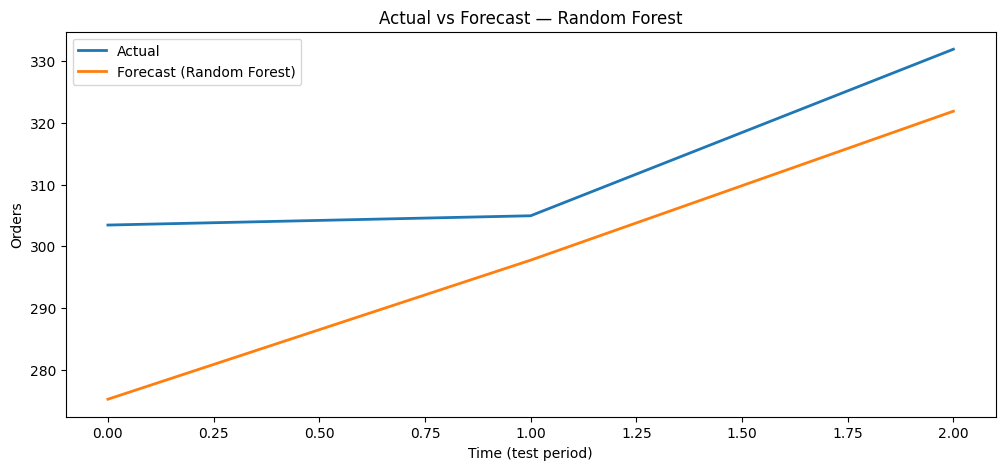

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(pred_rf, label="Forecast (Random Forest)", linewidth=2)
plt.title("Actual vs Forecast — Random Forest")
plt.xlabel("Time (test period)")
plt.ylabel("Orders")
plt.legend()
plt.show()
